<a href="https://colab.research.google.com/github/MoritzHaw/BPI2019_Colabatory/blob/main/Con.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py

In [ ]:
import pm4py
import numpy as np
import pandas as pd
import zipfile

In [ ]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

#zf = zipfile.ZipFile('/content/CSV_nGR_filtered') 
#log_csv = pd.read_pickle('/content/PKL_IVbGR_filtered')
log_csv = pd.read_csv('/content/CSV_Con_filtered', encoding='cp1252',sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

In [ ]:
log_csv

In [ ]:
def to_eventlog(dataset):
  # Convert log_csv to event_log
  parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}  # identify the case_id_key name (if not change it will simply be the nane of the coloumn)
  event_log = log_converter.apply(dataset, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
  return event_log

In [ ]:
event_log = to_eventlog(log_csv)

In [ ]:
from pm4py.statistics.traces.generic.pandas import case_statistics  # filter variants

def filter_by_variants(dataset):
        variants = case_statistics.get_variants_df(dataset, parameters={
            case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
            case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})
        return variants


# Miner & Graphen

In [ ]:
def direct_follow_graph(e_log):

  # visualize as direct follow graph

    from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
    dfg = dfg_discovery.apply(e_log)

    # Filter direct followed graph
    dfg, sa, ea = pm4py.discover_directly_follows_graph(e_log)
    activities_count = pm4py.get_event_attribute_values(e_log, "concept:name")

    # filter activites - only top 10 percent

    from pm4py.algo.filtering.dfg import dfg_filtering
    dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(dfg, sa, ea, activities_count, 0.2)

    # filter paths - only 10 percent

    dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_paths_percentage(dfg, sa, ea, activities_count, 0.1)
                                        
                                        

    from pm4py.visualization.dfg import visualizer as dfg_visualization
    gviz = dfg_visualization.apply(dfg, log=e_log, variant=dfg_visualization.Variants.FREQUENCY)
    dfg_visualization.view(gviz)

In [ ]:
# Heuristic miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer


def heuristic_miner(e_log):

    heu_net = heuristics_miner.apply_heu(event_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1000,
                                                              heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1000})
    plt.figure(figsize=(5,5))
                        
    gviz = hn_visualizer.apply(heu_net)
    hn_visualizer.view(gviz)

In [ ]:
# petri net from heuristic miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer


  # Visualise a Petri Net
def visualize_petri_heu(e_log, net, im, fm):
    gviz = pn_visualizer.apply(net, im, fm, log=e_log, variant=pn_visualizer.Variants.FREQUENCY)
    pn_visualizer.view(gviz)

def petri_from_heu(e_log, tresh: float, min_act_count, min_dfg_occurences):

    parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: tresh, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: min_act_count, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: min_dfg_occurences} 
    net, im, fm = heuristics_miner.apply(e_log, parameters=parameters)

    return net, im, fm      

In [ ]:
# process tree from inductive miner

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

def visualize_pt(tree):
    gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
    pt_visualizer.view(gviz)
 
def pt_from_inductive_im(e_log): # Produces a model with perfect replay fitness.

    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IM)
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IM)  
          

    #visualize_pt(tree)    
  
    return net, im, fm, tree

def pt_from_inductive_imf(e_log, tresh): # Produces a more precise model, without fitness guarantees, by eliminating some behavior.
    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf.value.Parameters.NOISE_THRESHOLD: tresh})
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IMf,
                                          parameters={inductive_miner.Variants.IMf.value.Parameters.NOISE_THRESHOLD: tresh})  #The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2
          
 
    #visualize_pt(tree) 
  
    return net, im, fm, tree  


def pt_from_inductive_imd(e_log, tresh): # A variant of inductive miner that considers only the directly-follows graph, for maximum performance. However, replay fitness guarantees are lost.
    net, im, fm = inductive_miner.apply(e_log, variant=inductive_miner.Variants.IMd, parameters={inductive_miner.Variants.IMd.value.Parameters.NOISE_THRESHOLD: tresh})
    tree = inductive_miner.apply_tree(e_log, variant=inductive_miner.Variants.IMd,
                                          parameters={inductive_miner.Variants.IMd.value.Parameters.NOISE_THRESHOLD: tresh})  #The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2
          

    #visualize_pt(tree) 
  
    return net, im, fm, tree  


In [ ]:
# Convert process tree into a Petri Net
from pm4py.objects.conversion.process_tree import converter as pt_converter

def petri_from_pt(tree, e_log):
  
  net, im, fm = pt_converter.apply(tree)
  ## Visualise
  gviz = pn_visualizer.apply(net, im, fm, 
                            variant=pn_visualizer.Variants.FREQUENCY, 
                            log=e_log)
  pn_visualizer.view(gviz)

  return net, im, fm

In [ ]:

from pm4py.objects.conversion.wf_net import converter as wf_net_converter

def pt_from_alpha(e_log):
  net, im, fm = pm4py.discover_petri_net_alpha(log)
  

  tree = wf_net_converter.apply(net, im, fm)
  print(tree)

# BPMN

In [ ]:
#bpmn

from pm4py.objects.conversion.process_tree import converter
from pm4py.objects.bpmn.layout import layouter


def to_bpmn(pt_tree, name: str):

  bpmn = converter.apply(pt_tree, variant=converter.Variants.TO_BPMN)
  bpmn = layouter.apply(bpmn, variant=layouter.Variants.GRAPHVIZ)
  #pm4py.visualization.bpmn.visualizer.matplotlib_view(bpmn)
  pm4py.write_bpmn(bpmn, name, enable_layout=True)

# Testing

In [ ]:
def calculate_score(fitness, prec, gen, simp):
    fit_sum = fitness.get('perc_fit_traces') + (fitness.get('average_trace_fitness')*100) + (fitness.get('log_fitness')*100) + fitness.get('percentage_of_fitting_traces')
    fit = (fit_sum/4)/100
    score = fit + prec + gen + simp
    return score

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

def test(e_log, net, im, fm):
        fitness = replay_fitness_evaluator.apply(e_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
        print('Fitness: ', fitness)
        
        #perc_fit_traces': 87.56476683937824, 'average_trace_fitness': 0.9990753857628418, 'log_fitness': 0.9983287356471942, 'percentage_of_fitting_traces'
        prec = precision_evaluator.apply(e_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        print('Precision: ', prec)

        gen = generalization_evaluator.apply(e_log, net, im, fm)
        print('Generalization: ', gen)

        simp = simplicity_evaluator.apply(net)
        print('Simplicity: ', simp)

        score = calculate_score(fitness, prec, gen, simp)
        return score

In [ ]:

def get_best_petri(e_log):

   highest_score = []
   min_dfg_occurences = [0, 300, 600]
   min_act_count = [0,300, 600]
   dependency_tresh = [0.0, 0.5, 0.99]
   score = 0
   
   for k in dependency_tresh:
    for j in min_act_count:
     for i in min_dfg_occurences:
          net, im, fm = petri_from_heu(e_log, k, j, i)
          calc_score = test(e_log, net, im, fm)
          if calc_score > score:
            score = calc_score
            highest_score.clear()
            highest_score.append([k, j, i, score])

   print(highest_score)
   return highest_score

In [ ]:
def get_best_pt_from_inductive(e_log):
   
   
   dependency_tresh = [0.0, 0.19,  0.39,  0.59,  0.79, 0.99]
   

   def test_im():
      score = 0
      highest_score = []
      net, im, fm, tree = pt_from_inductive_im(e_log)
      calc_score = test(e_log, net, im, fm)
      highest_score.append([calc_score])
      return highest_score

   def test_imf():
      score = 0
      highest_score = []
      for k in dependency_tresh:
              net, im, fm, tree = pt_from_inductive_imf(e_log, k)
              calc_score = test(e_log, net, im, fm)
              if calc_score > score:
                score = calc_score
                highest_score.clear()
                highest_score.append([k, score])
      return highest_score

   def test_imd():
      score = 0
      highest_score = []
      for k in dependency_tresh:
              net, im, fm, tree = pt_from_inductive_imd(e_log, k)
              calc_score = test(e_log, net, im, fm)
              if calc_score > score:
                score = calc_score
                highest_score.clear()
                highest_score.append([k, score])
      return highest_score

   im_score = test_im()
   imf_score = test_imf()
   imd_score = test_imd()

   print('im_score: ', im_score)
   print('imf_score: ', imf_score)
   print('imd_score: ', imd_score)
   return im_score, imf_score, imd_score

# Filter Mehtods to improve visibility

In [ ]:
# filter between EC Purchase Orders(SRM) and without SRM

from pm4py.algo.filtering.pandas.attributes import attributes_filter

def filter_log_by_x(dataset, doc_type: str, attr_key: str, pos_neg: bool):

    df_traces = attributes_filter.apply(dataset, [doc_type],
                                          parameters={attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name", attributes_filter.Parameters.ATTRIBUTE_KEY: attr_key, attributes_filter.Parameters.POSITIVE: pos_neg})
    
    return df_traces


def filter_eventlog_by_docType(e_log, doc_type: str):
   
  
    tracefilter_pos = attributes_filter.apply(e_log, doc_Type,
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "case:doc:type", attributes_filter.Parameters.POSITIVE: True})
    
    #tracefilter_neg = attributes_filter.apply(e_log, [doc_type],parameters={
    #                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "case:doc:type", attributes_filter.Parameters.POSITIVE: False})
    
    return tracefilter_pos# tracefilter_neg

In [ ]:
# compare before and after filtering date 

import matplotlib.pyplot as plt
import seaborn as sns

def comp_value_in_data(dataset1):

    data = dict(dataset1)

    plt.style.use('ggplot')

    x = list(data.keys())
    events = list(dataset1)

    x_pos = [i for i, _ in enumerate(x)]
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    color = sns.color_palette("muted")
    plt.figure(1, figsize=(5, 5))  # size
    plt.bar(x_pos, events, color=color)
    
 
    plt.ylabel("Events")
    #plt.title("Energy output from various fuel sources")
    plt.grid(False)

    plt.xticks(x_pos, x, rotation='vertical')
    plt.axhline(y=0, color='black')

    plt.show()

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter

def filter_log_frequency(e_log, dataset):
   filtered_log = variants_filter.filter_log_variants_percentage(e_log, percentage=calc_percentage_varfilter(dataset))
   return filtered_log

In [ ]:
# 5 most frequent variant 

def calc_percentage_varfilter(dataset):
  share_of_frequent = 0
  for i in range(0,4): 
    share_of_frequent = (dataset['variant'].value_counts()[i]/dataset['variant'].count()) + share_of_frequent
  #if share_of_frequent < 0.5:
    #share_of_frequent = share_of_frequent + (0.5-share_of_frequent)
  print(share_of_frequent)
  return share_of_frequent


# MAIN

1. Filter by 5 most frequent variants

In [ ]:
filtered_log = filter_log_frequency(event_log, log_csv)

0.7530055982134664


In [ ]:
score_inductive_SRM = get_best_pt_from_inductive(filtered_log) 
#im_score:  [[3.9858636176189552]]
#imf_score:  [[0.0, 3.9858636176189552]]
#imd_score:  [[0.0, 3.9858636176189552]]

In [ ]:
log_csv['variant'].value_counts()

Vendor creates invoice,Create Purchase Order Item,Change Approval for Purchase Order,Record Invoice Receipt                                                                                                                                                                                                                                                                                                                                                                                792
Vendor creates invoice,Create Purchase Order Item,Change Approval for Purchase Order,Record Invoice Receipt,Clear Invoice                                                                                                                                                                                                                                                                                                                                                                  240
Vendor creates invoice,Create Purchase Ord

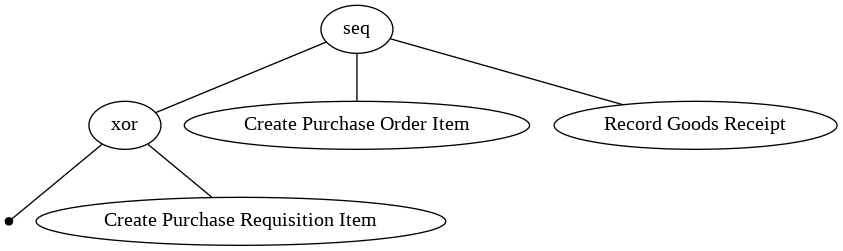

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

Generalization:  0.9858636176189551
Simplicity:  1.0


In [ ]:
net, im, fm, tree = pt_from_inductive_imf(filtered_log, 0)
visualize_pt(tree)
test(filtered_log, net, im, fm)
to_bpmn(tree, "Con_filtered.bpmn")

In [ ]:
score_petri_SRM = get_best_petri(filtered_log) # [[0.0, 0, 0, 3.9858636176189552]]

replaying log with TBR, completed variants ::   0%|          | 0/267 [00:00<?, ?it/s]

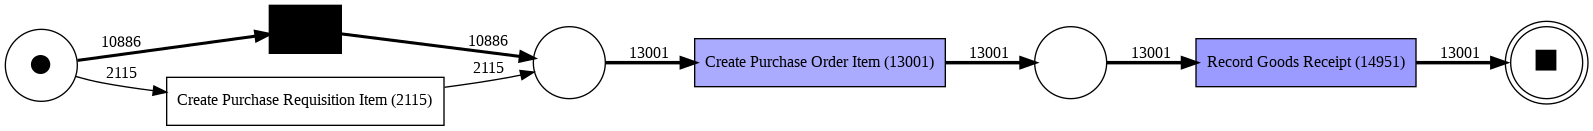

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

Generalization:  0.9858636176189551
Simplicity:  1.0


3.9858636176189552

In [ ]:
net,im,fm = petri_from_heu(filtered_log, 0, 0, 0)
visualize_petri_heu(event_log, net, im, fm) #### event_log
test(filtered_log, net, im, fm)

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

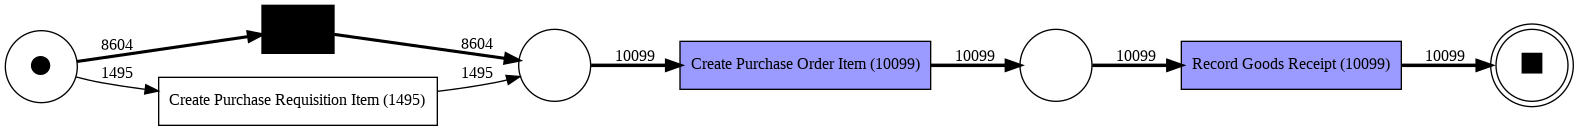

(places: [ p_3, p_4, sink, source ]
 transitions: [ (d867066c-3360-44f1-9e42-48a2508313f0, 'Create Purchase Requisition Item'), (ee9de99a-1123-4ef3-8c2e-ae94df7a9174, 'Create Purchase Order Item'), (ff3bd386-a441-41f0-9568-94e587192e0e, 'Record Goods Receipt'), (skip_1, None) ]
 arcs: [ (d867066c-3360-44f1-9e42-48a2508313f0, 'Create Purchase Requisition Item')->p_3, (ee9de99a-1123-4ef3-8c2e-ae94df7a9174, 'Create Purchase Order Item')->p_4, (ff3bd386-a441-41f0-9568-94e587192e0e, 'Record Goods Receipt')->sink, (skip_1, None)->p_3, p_3->(ee9de99a-1123-4ef3-8c2e-ae94df7a9174, 'Create Purchase Order Item'), p_4->(ff3bd386-a441-41f0-9568-94e587192e0e, 'Record Goods Receipt'), source->(d867066c-3360-44f1-9e42-48a2508313f0, 'Create Purchase Requisition Item'), source->(skip_1, None) ],
 Marking({source: 1}),
 Marking({sink: 1}))

In [ ]:
petri_from_pt(tree, filtered_log) # event_log???